/Users/silvanocerza/.virtualenvs/haystack38/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


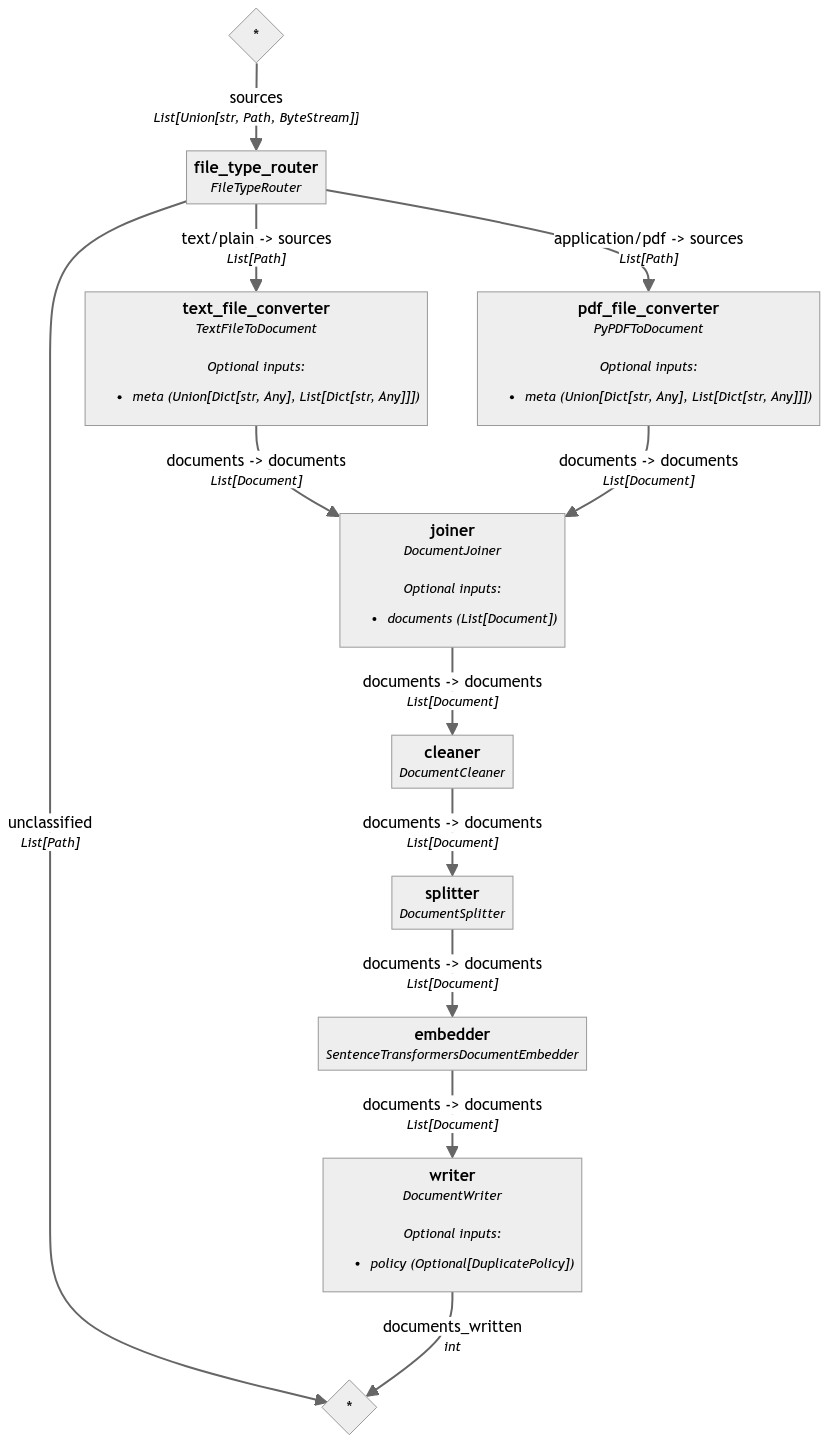

🚅 Components
  - file_type_router: FileTypeRouter
  - text_file_converter: TextFileToDocument
  - pdf_file_converter: PyPDFToDocument
  - joiner: DocumentJoiner
  - cleaner: DocumentCleaner
  - splitter: DocumentSplitter
  - embedder: SentenceTransformersDocumentEmbedder
  - writer: DocumentWriter
🛤️ Connections
  - file_type_router -> text_file_converter (List[Path])
  - file_type_router -> pdf_file_converter (List[Path])
  - text_file_converter -> joiner (List[Document])
  - pdf_file_converter -> joiner (List[Document])
  - joiner -> cleaner (List[Document])
  - cleaner -> splitter (List[Document])
  - splitter -> embedder (List[Document])
  - embedder -> writer (List[Document])

In [1]:
from haystack import Pipeline
from haystack.components.converters import PyPDFToDocument, TextFileToDocument
from haystack.components.embedders import SentenceTransformersDocumentEmbedder
from haystack.components.joiners import DocumentJoiner
from haystack.components.preprocessors import DocumentCleaner, DocumentSplitter
from haystack.components.routers import FileTypeRouter
from haystack.components.writers import DocumentWriter
from haystack.document_stores.in_memory import InMemoryDocumentStore

# Create the indexing pipeline
indexing_pipeline = Pipeline()
indexing_pipeline.add_component(
    instance=FileTypeRouter(mime_types=["text/plain", "application/pdf"]), name="file_type_router"
)
indexing_pipeline.add_component(instance=TextFileToDocument(), name="text_file_converter")
indexing_pipeline.add_component(instance=PyPDFToDocument(), name="pdf_file_converter")
indexing_pipeline.add_component(instance=DocumentJoiner(), name="joiner")
indexing_pipeline.add_component(instance=DocumentCleaner(), name="cleaner")
indexing_pipeline.add_component(
    instance=DocumentSplitter(split_by="sentence", split_length=250, split_overlap=30), name="splitter"
)
indexing_pipeline.add_component(
    instance=SentenceTransformersDocumentEmbedder(model="sentence-transformers/all-MiniLM-L6-v2"), name="embedder"
)
indexing_pipeline.add_component(instance=DocumentWriter(document_store=InMemoryDocumentStore()), name="writer")

indexing_pipeline.connect("file_type_router.text/plain", "text_file_converter.sources")
indexing_pipeline.connect("file_type_router.application/pdf", "pdf_file_converter.sources")
indexing_pipeline.connect("text_file_converter.documents", "joiner.documents")
indexing_pipeline.connect("pdf_file_converter.documents", "joiner.documents")
indexing_pipeline.connect("joiner.documents", "cleaner.documents")
indexing_pipeline.connect("cleaner.documents", "splitter.documents")
indexing_pipeline.connect("splitter.documents", "embedder.documents")
indexing_pipeline.connect("embedder.documents", "writer.documents")

indexing_pipeline

/Users/silvanocerza/.virtualenvs/haystack38/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


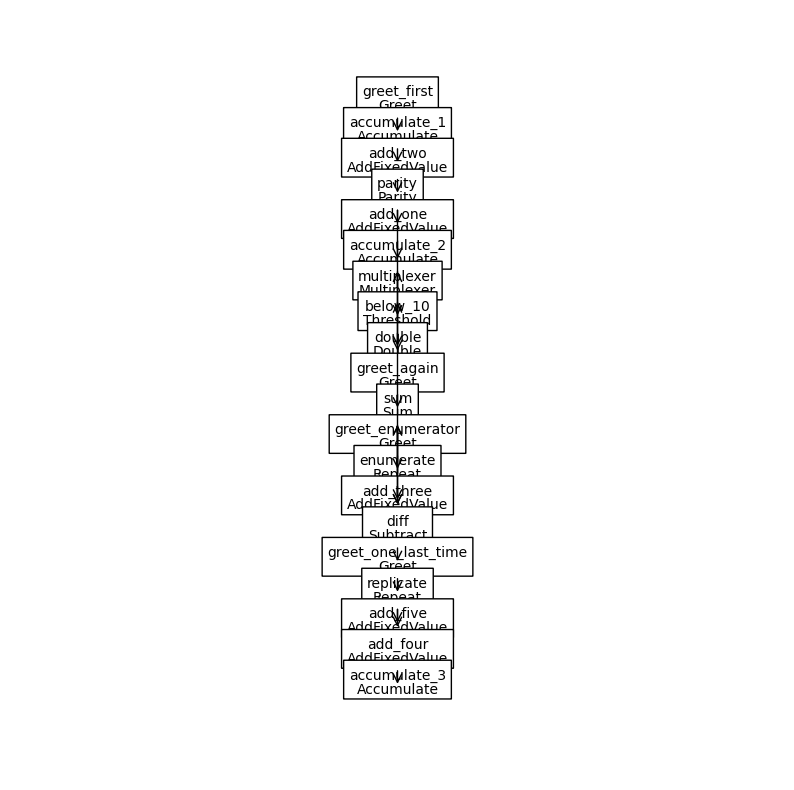

In [1]:
from haystack.components.others import Multiplexer
from haystack.core.pipeline import Pipeline
from haystack.testing.sample_components import (
    Accumulate,
    AddFixedValue,
    Double,
    Greet,
    Parity,
    Repeat,
    Subtract,
    Sum,
    Threshold,
)

pipeline = Pipeline(max_loops_allowed=2)
pipeline.add_component("greet_first", Greet(message="Hello, the value is {value}."))
pipeline.add_component("accumulate_1", Accumulate())
pipeline.add_component("add_two", AddFixedValue(add=2))
pipeline.add_component("parity", Parity())
pipeline.add_component("add_one", AddFixedValue(add=1))
pipeline.add_component("accumulate_2", Accumulate())

pipeline.add_component("multiplexer", Multiplexer(type_=int))
pipeline.add_component("below_10", Threshold(threshold=10))
pipeline.add_component("double", Double())

pipeline.add_component("greet_again", Greet(message="Hello again, now the value is {value}."))
pipeline.add_component("sum", Sum())

pipeline.add_component("greet_enumerator", Greet(message="Hello from enumerator, here the value became {value}."))
pipeline.add_component("enumerate", Repeat(outputs=["first", "second"]))
pipeline.add_component("add_three", AddFixedValue(add=3))

pipeline.add_component("diff", Subtract())
pipeline.add_component("greet_one_last_time", Greet(message="Bye bye! The value here is {value}!"))
pipeline.add_component("replicate", Repeat(outputs=["first", "second"]))
pipeline.add_component("add_five", AddFixedValue(add=5))
pipeline.add_component("add_four", AddFixedValue(add=4))
pipeline.add_component("accumulate_3", Accumulate())

pipeline.connect("greet_first", "accumulate_1")
pipeline.connect("accumulate_1", "add_two")
pipeline.connect("add_two", "parity")

pipeline.connect("parity.even", "greet_again")
pipeline.connect("greet_again", "sum.values")
pipeline.connect("sum", "diff.first_value")
pipeline.connect("diff", "greet_one_last_time")
pipeline.connect("greet_one_last_time", "replicate")
pipeline.connect("replicate.first", "add_five.value")
pipeline.connect("replicate.second", "add_four.value")
pipeline.connect("add_four", "accumulate_3")

pipeline.connect("parity.odd", "add_one.value")
pipeline.connect("add_one", "multiplexer.value")
pipeline.connect("multiplexer", "below_10")

pipeline.connect("below_10.below", "double")
pipeline.connect("double", "multiplexer.value")

pipeline.connect("below_10.above", "accumulate_2")
pipeline.connect("accumulate_2", "diff.second_value")

pipeline.connect("greet_enumerator", "enumerate")
pipeline.connect("enumerate.second", "sum.values")

pipeline.connect("enumerate.first", "add_three.value")
pipeline.connect("add_three", "sum.values")

pipeline.new_draw()